<img src="Imagenes/aug_fer.jpg" alt="Imagen creada con inteligencia artificial y editada con Microsoft Paint" style="border-radius: 15px">


*Imagen creada con inteligencia artificial.*


## **INTRODUCCIÓN**

Como se ha visto en el **EDA** del dataset, no todas las etiquetas, es decir, las expresiones faciales, están igualmente representadas. Por ejemplo, en el datset de partida, la etiqueta 3 (**Felicidad**) tiene 8989 entradas, mientras que la etiqueta 1 (**Asco**) tiene tan solo 547 entradas.

Pese a que 547 podría parecer "no pocas" entradas, este desbalanceo puede suponer una merma importante en la calidad de un modelo. Lo ideal sería aumentar el dataset con más fotografías, pero esto es tedioso, lleva tiempo y no es lo más práctico.

La opción que aquí se muestra es crear fotografías nuevas a partir de las ya existentes, volteándolas horizontalmente, añadiendo algo de ruido y rotando un poco las **imagenes**. De esta forma, y haciéndolo según sea el desbalanceo, podemos conseguir un nuevo dataset algo más balanceado.  
  
Para cargaremos los tres datasets, los balancearemos individualmente y al final los uniremos en un dataset balanceado.

> Este notebook puede parecer algo complicado pero durante todo el notebook habrá explicaciones.
> 
> Sí, efectivamente, la imagen del banner es un guiño al hecho de que aquí se arreglan fotos.
> 
> Al final del notebook hay un resumen/explicación.



## **BIBLIOTECAS USADAS:**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import ast  
from scipy.ndimage import rotate  
import random 
pd.options.mode.chained_assignment = None

## **CARGA DEL DASET**

In [2]:
df_train = pd.read_csv('./datos/fer2013/dataframe_individuales/df_train.csv')
df_test= pd.read_csv('./datos/fer2013/dataframe_individuales/df_test.csv')
df_val= pd.read_csv('./datos/fer2013/dataframe_individuales/df_val.csv')

## **FLIP HORIZONTAL**

>Después del proceso de **data augmentation**, todas las clases tendrán la misma cantidad de **fotografías** (arrays en verdad).    
>Igualaremos el número de fotografías a la clase que más tiene, a esta, de momento, no le haremos nada.    
>Para las demás clases, haremos distintos procesos hasta que todas se igualen.  
>El primer proceso será un "flip horizontal.  


In [3]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3589 entries, 0 to 3588
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  3589 non-null   int64 
 1   pixels   3589 non-null   object
 2   Usage    3589 non-null   object
dtypes: int64(1), object(2)
memory usage: 84.2+ KB


In [4]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3589 entries, 0 to 3588
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  3589 non-null   int64 
 1   pixels   3589 non-null   object
 2   Usage    3589 non-null   object
dtypes: int64(1), object(2)
memory usage: 84.2+ KB


## **TRAIN**

In [5]:
df_train['emotion'].value_counts()

emotion
3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: count, dtype: int64

>Haremos **"flip"** a tantas entradas,lineas, por etiqueta de expresión facial como sea necesario para igualar la clase **"3"**.
>
>Las clases **"1"** y **"5"** necesitan otros procesos para poder tener suficiente cantidad.

In [6]:
def seleccionar_aleatoriamente(df, emotion, n):
    return df[df['emotion'] == emotion].sample(n=n, random_state=42)
df_emotion_6 = seleccionar_aleatoriamente(df_train, 6,2250)
df_emotion_4 = seleccionar_aleatoriamente(df_train, 4,2385)
df_emotion_2 = seleccionar_aleatoriamente(df_train, 2, 3118)
df_emotion_0 = seleccionar_aleatoriamente(df_train, 0, 3220)
df_emotion_5 = df_train[df_train['emotion'] == 5]
df_emotion_1 = df_train[df_train['emotion'] == 1]
df_train_espejo = pd.concat([df_emotion_6, df_emotion_4, df_emotion_2, df_emotion_0, df_emotion_5, df_emotion_1])
df_train_espejo = df_train_espejo.reset_index(drop=True) 


In [7]:
df_train_espejo['emotion'].value_counts()

emotion
0    3220
5    3171
2    3118
4    2385
6    2250
1     436
Name: count, dtype: int64

>**Vemos que si sumamos estas (es decir, las lineas que serán volteadas) y los conteos de los datasets de partida, da como resultado que las clases se equilibran (excepto las dos más desfavorecidas)... en otras palabras, vamos bien.**

### **TEST**

In [8]:
df_test['emotion'].value_counts()

emotion
3    895
4    653
6    607
2    496
0    467
5    415
1     56
Name: count, dtype: int64

In [9]:
df_emotion_4_test = seleccionar_aleatoriamente(df_test, 4, 242)
df_emotion_6_test = seleccionar_aleatoriamente(df_test, 6,288)
df_emotion_2_test = seleccionar_aleatoriamente(df_test, 2, 399)
df_emotion_0_test = seleccionar_aleatoriamente(df_test, 0, 428)
df_emotion_5_test = df_test[df_test['emotion'] == 5]
df_emotion_1_test = df_test[df_test['emotion'] == 1]
df_test_espejo = pd.concat([df_emotion_6_test, df_emotion_4_test, df_emotion_2_test, df_emotion_0_test, df_emotion_5_test, df_emotion_1_test])
df_test_espejo = df_test_espejo.reset_index(drop=True) 

In [10]:
df_test_espejo['emotion'].value_counts()

emotion
0    428
5    415
2    399
6    288
4    242
1     56
Name: count, dtype: int64

### **VAL**

In [11]:
df_val['emotion'].value_counts()

emotion
3    879
6    626
4    594
2    528
0    491
5    416
1     55
Name: count, dtype: int64

In [12]:
df_emotion_6_val = seleccionar_aleatoriamente(df_val, 6, 253)
df_emotion_4_val = seleccionar_aleatoriamente(df_val, 4, 285)
df_emotion_2_val = seleccionar_aleatoriamente(df_val, 2, 351)
df_emotion_0_val = seleccionar_aleatoriamente(df_val, 0, 388)
df_emotion_5_val = df_val[df_val['emotion'] == 5]
df_emotion_1_val = df_val[df_val['emotion'] == 1]
df_val_espejo = pd.concat([df_emotion_6_val, df_emotion_4_val, df_emotion_2_val, df_emotion_0_val, df_emotion_5_val, df_emotion_1_val])
df_val_espejo = df_val_espejo.reset_index(drop=True)


In [13]:
df_val_espejo['emotion'].value_counts()

emotion
5    416
0    388
2    351
4    285
6    253
1     55
Name: count, dtype: int64

In [14]:
def flip_image_horizontal(pixel_string):
    try:
        pixel_values = list(map(int, pixel_string.split()))
        size = int(np.sqrt(len(pixel_values)))
        image_matrix = np.array(pixel_values).reshape((size, size))
        flipped_image_matrix = np.fliplr(image_matrix)
        flipped_pixel_string = ' '.join(map(str, flipped_image_matrix.flatten()))
        return flipped_pixel_string
    except Exception as e:
        print(f"Error al procesar la imagen: {e}")
        return pixel_string  # Devuelve la cadena original en caso de error



>**Aquí definimos la función que dará la vuelta horizontalmente a las fotografías (realmente se la da a la cadena).**


In [15]:
df_train_espejo.loc[:, 'pixels'] = df_train_espejo['pixels'].apply(lambda x: flip_image_horizontal(x))
df_test_espejo.loc[:, 'pixels'] = df_test_espejo['pixels'].apply(lambda x: flip_image_horizontal(x))
df_val_espejo.loc[:, 'pixels'] = df_val_espejo['pixels'].apply(lambda x: flip_image_horizontal(x))

> **Y con estas llamadas a la función, le damos la vuelta a las líneas que habíamos elegido antes.**

## **VISUALIZACIÓN.**  
> **Visualizaremos las imágenes para verificar si ha ido bien. Primero las visualizaremos sin el flip y luego con el flip. Dado que las imágenes que han sido volteadas en las clases menos desfavorecidas se han elegido aleatoriamente, solo observaremos esto en las clases más desfavorecidas (que se han volteado completamente).**


In [16]:
emotion_labels = {0: 'Enfado',1: 'Asco',2: 'Miedo',3: 'Felicidad',4: 'Tristeza',5: 'Sorpresa',6: 'Neutral'}#No es necesario visualizar todas las clases para ver que ha ido bien.
def mostrar_imagenes_emocion(df, emotion):
    filtered_df = df[df['emotion'] == emotion].head(3)  
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle(f'Emoción: {emotion_labels[emotion]}', fontsize=16)  
    for i, ax in enumerate(axes):
        if i < len(filtered_df):
            pixels = np.array(filtered_df.iloc[i]['pixels'].split(), dtype='int').reshape(48, 48)
            ax.imshow(pixels, cmap='gray')
            ax.axis('off')   
    plt.tight_layout()
    plt.show()



> **Esta función nos mostrará las imágenes.**

## **SIN VOLTEAR**

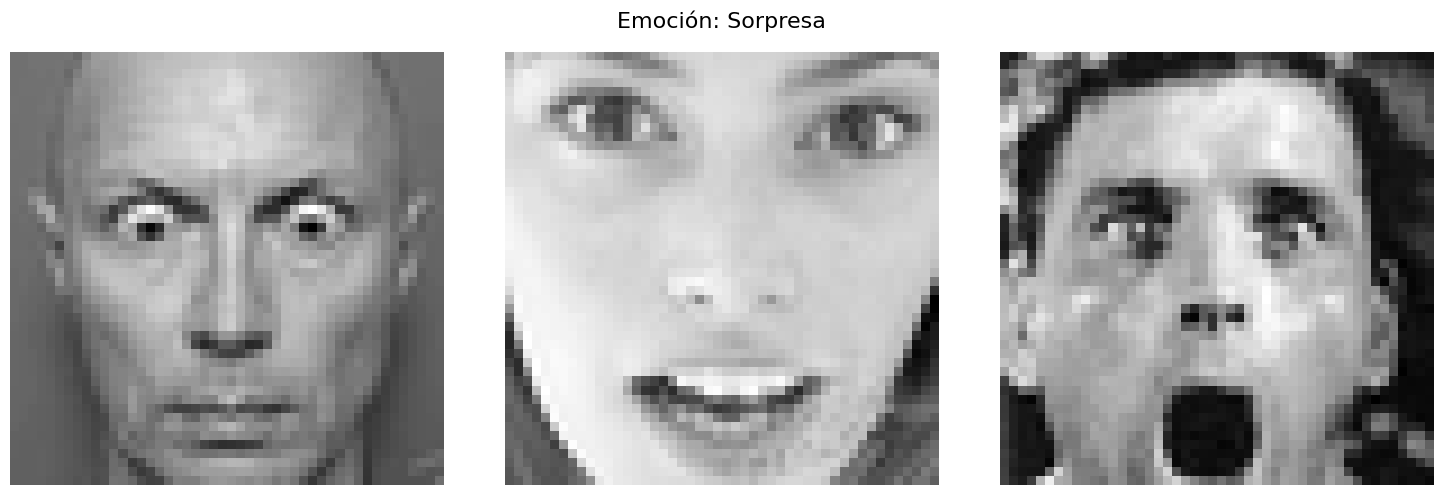

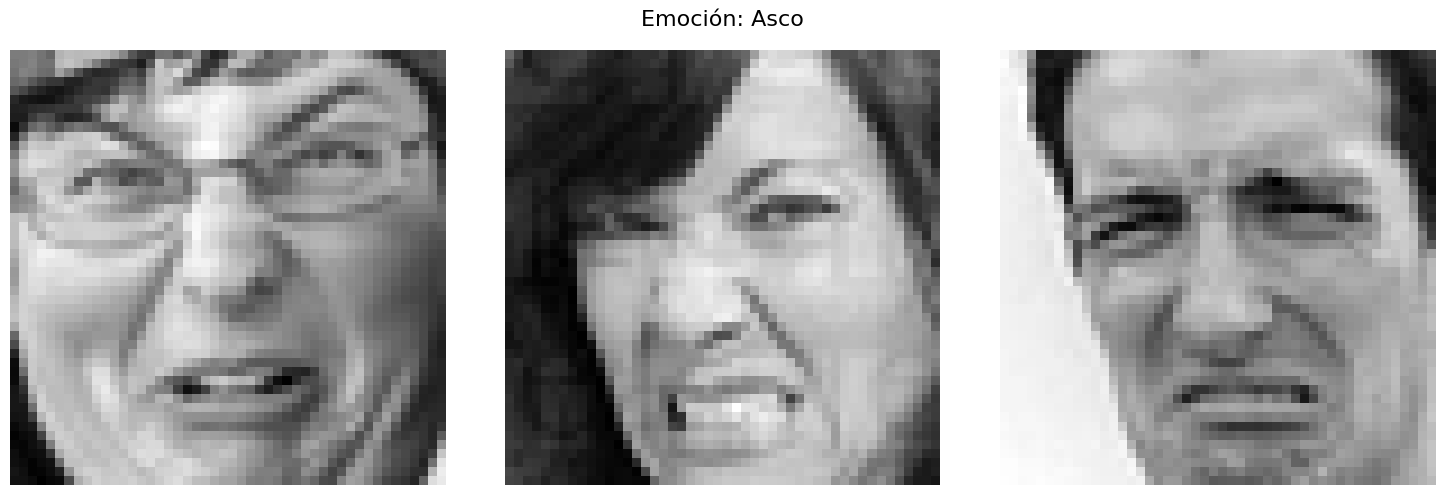

In [17]:
for emotion in [ 5, 1]:
    mostrar_imagenes_emocion(df_train, emotion)


## **VOLTEADAS**

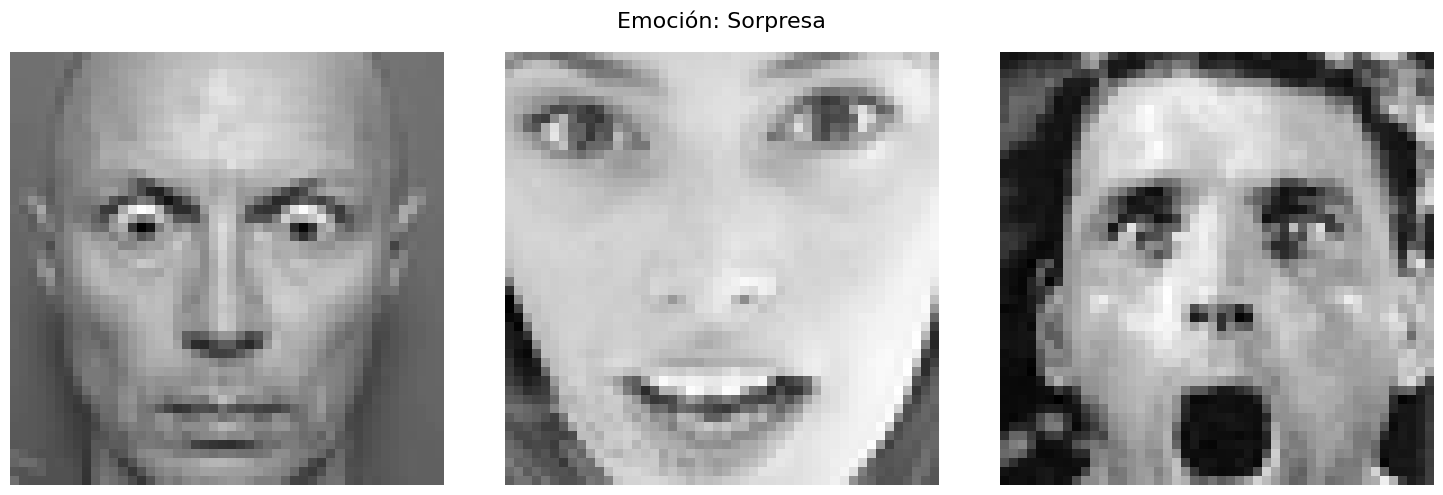

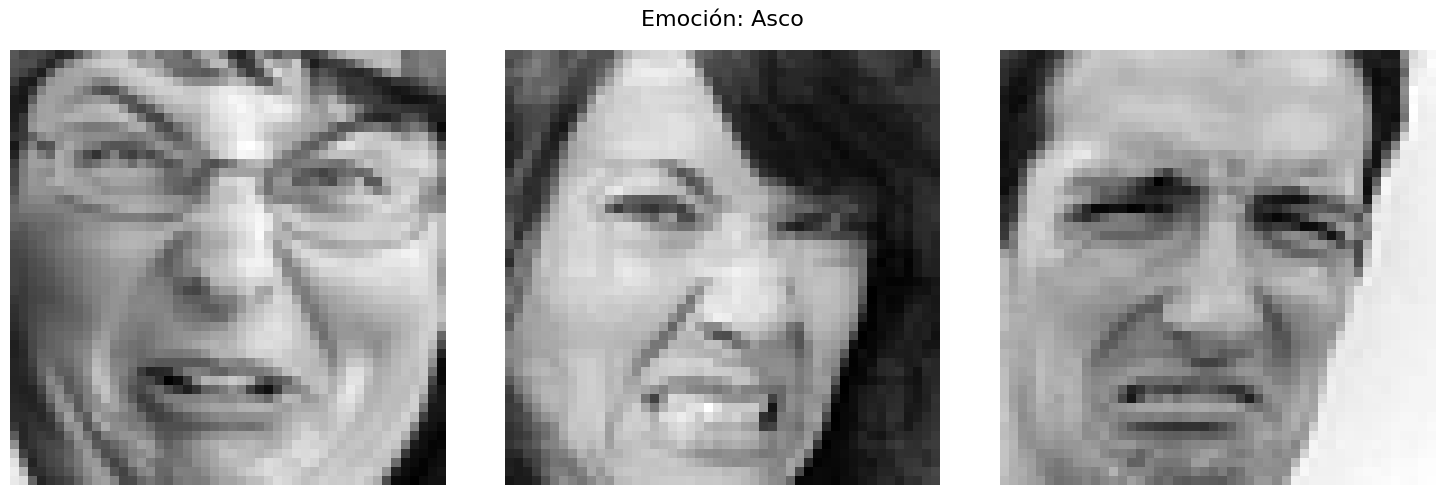

In [18]:
for emotion in [ 5, 1]:
    mostrar_imagenes_emocion(df_train_espejo, emotion)

> **Hemos comprobado que el volteo ha sido exitoso. Ahora podemos unir los datasets volteados con sus respectivos sin voltear.**


## **UNIÓN DE LOS DATASETS VOLTEADOS CON LOS DATASETS ORIGINALES**

In [19]:
df_train = pd.concat([df_train_espejo, df_train], ignore_index=True)
df_test = pd.concat([df_test_espejo, df_test], ignore_index=True)
df_val = pd.concat([df_val_espejo, df_val], ignore_index=True)  


## **COMPROBAMOS**

In [20]:
print("El dataset de entenamiento ha quedado así:")
print(df_train['emotion'].value_counts())
print()
print("El dataset de validación ha quedado así:")
print(df_val['emotion'].value_counts())
print()
print("El dataset pruebas ha quedado así:")
print(df_test['emotion'].value_counts())




El dataset de entenamiento ha quedado así:
emotion
6    7215
4    7215
2    7215
0    7215
3    7215
5    6342
1     872
Name: count, dtype: int64

El dataset de validación ha quedado así:
emotion
6    879
4    879
2    879
0    879
3    879
5    832
1    110
Name: count, dtype: int64

El dataset pruebas ha quedado así:
emotion
6    895
4    895
2    895
0    895
3    895
5    830
1    112
Name: count, dtype: int64


>**Vemos que solo las clases 1 (Asco/disgusto) y 5 (Sorpresa) están descompensadas. La clase 5 está poco descompensada, mientras que la clase 1 está bastante descompensada.**   **¿Qué significa esto? Significa que vamos bien.**

In [21]:
df_train['Usage'].value_counts() 

Usage
Training    43289
Name: count, dtype: int64

In [22]:
df_test['Usage'].value_counts()

Usage
PublicTest    5417
Name: count, dtype: int64

In [23]:
df_val['Usage'].value_counts()

Usage
PrivateTest    5337
Name: count, dtype: int64

> **No se han mezclado durante el proceso.**

## **AÑADIDO DE RUIDO**  

>**Se le hará primero solo a la etiqueta 1 (la más subrepresentada), a todas las entradas.**

In [24]:
def add_gaussian_noise(image_str, var=0.1):
    # Convertir la cadena de entrada en una lista de enteros
    image_list = list(map(int, image_str.split()))
    # Calcular el tamaño de la imagen (asumimos que es una imagen cuadrada)
    size = int(len(image_list) ** 0.5)
    # Asegurarse de que la lista puede formar una imagen cuadrada
    assert size * size == len(image_list), "La longitud de la lista no es un cuadrado perfecto"
    # Convertir la lista en un array numpy 2D
    image_array = np.array(image_list).reshape((size, size))
    # Definir la media del ruido gaussiano
    mean = 0
    # Calcular la desviación estándar del ruido gaussiano
    sigma = np.sqrt(var)
    # Generar el ruido gaussiano
    gauss = np.random.normal(mean, sigma, (size, size))
    # Añadir el ruido a la imagen y asegurar que los valores estén entre 0 y 255
    noisy = np.clip(image_array + gauss * 70, 0, 255).astype(np.uint8)
    # Convertir el array ruidoso en una lista aplanada
    noisy_list = noisy.flatten().tolist()
    # Devolver la lista como una cadena de texto
    return ' '.join(map(str, noisy_list))

>**Aquí se define la función que añade ruido gaussiano.**

In [25]:
df_train_ruido = df_train[df_train['emotion'] == 1] 
df_train_control = df_train[df_train['emotion'] == 1] #Para poder controlar. 

df_test_ruido = df_test[df_test['emotion'] == 1] 
df_test_control = df_test[df_test['emotion'] == 1] #Para poder controlar. 

df_val_ruido = df_val[df_val['emotion'] == 1] 
df_val_control = df_val[df_val['emotion'] == 1] #Para poder controlar.

>**Aquí se filtran los dataframes por la etiqueta (en este caso, la 1) a la que le queremos añadir ruido.**

In [26]:
df_train_ruido.loc[:, 'pixels'] = df_train_ruido['pixels'].apply(lambda x: add_gaussian_noise(x, var=0.006)) #Tras experimentar con varios niveles de ruido (controlado por 'var'), 
df_test_ruido.loc[:, 'pixels'] = df_test_ruido['pixels'].apply(lambda x: add_gaussian_noise(x, var=0.006)) #este parece funcionar bien. Se siguen reconociendo las caras, 
df_val_ruido.loc[:, 'pixels'] = df_val_ruido['pixels'].apply(lambda x: add_gaussian_noise(x, var=0.006)) #pero también se observa el ruido añadido.

>**Aquí llamamos a la función que añade ruido gaussiano.**

## **VISUALIZACIÓN.**  
### **PRIMERO SIN RUIDO**  


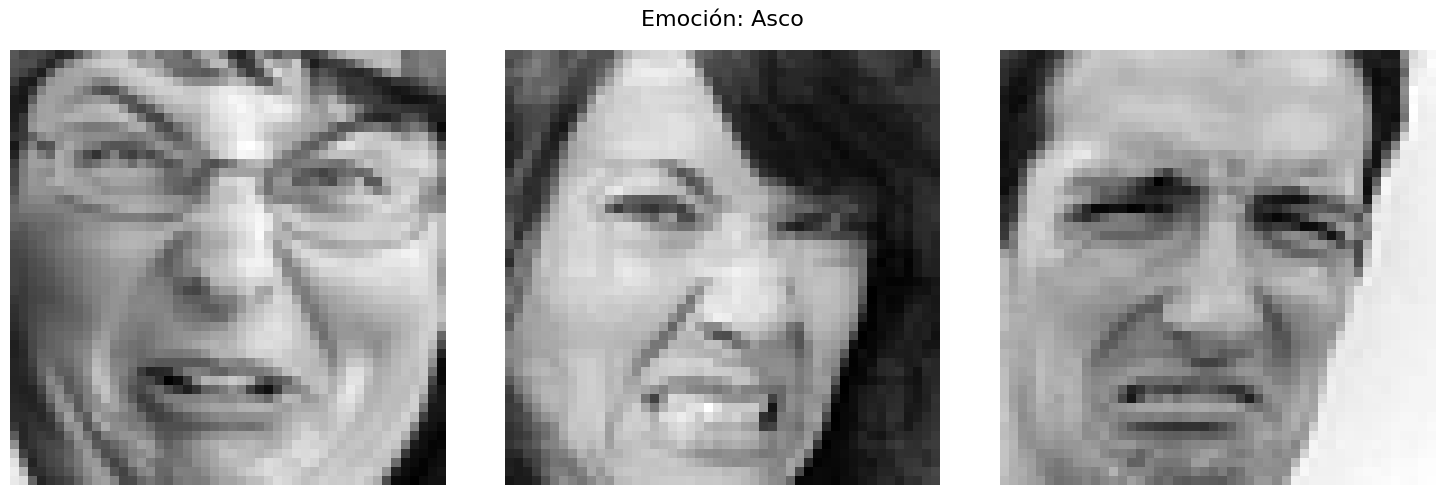

In [27]:
for emotion in [1]:
    mostrar_imagenes_emocion(df_train_control, emotion)

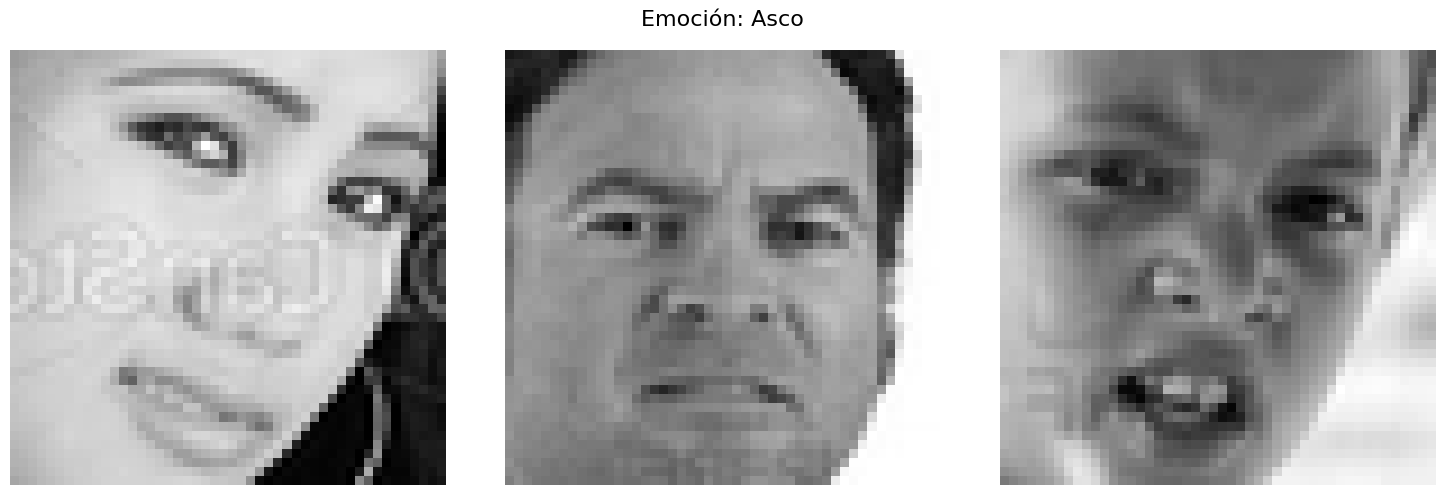

In [28]:
for emotion in [1]:
    mostrar_imagenes_emocion(df_test_control, emotion)

## **AHORA CON RUIDO**

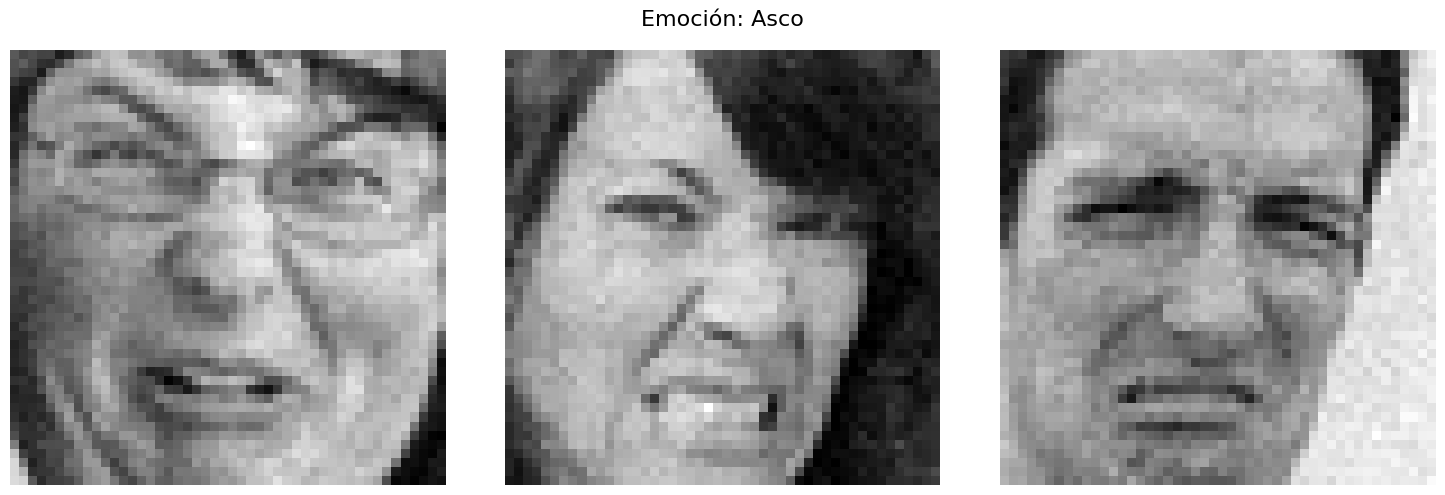

In [29]:
for emotion in [1]:
    mostrar_imagenes_emocion(df_train_ruido, emotion)

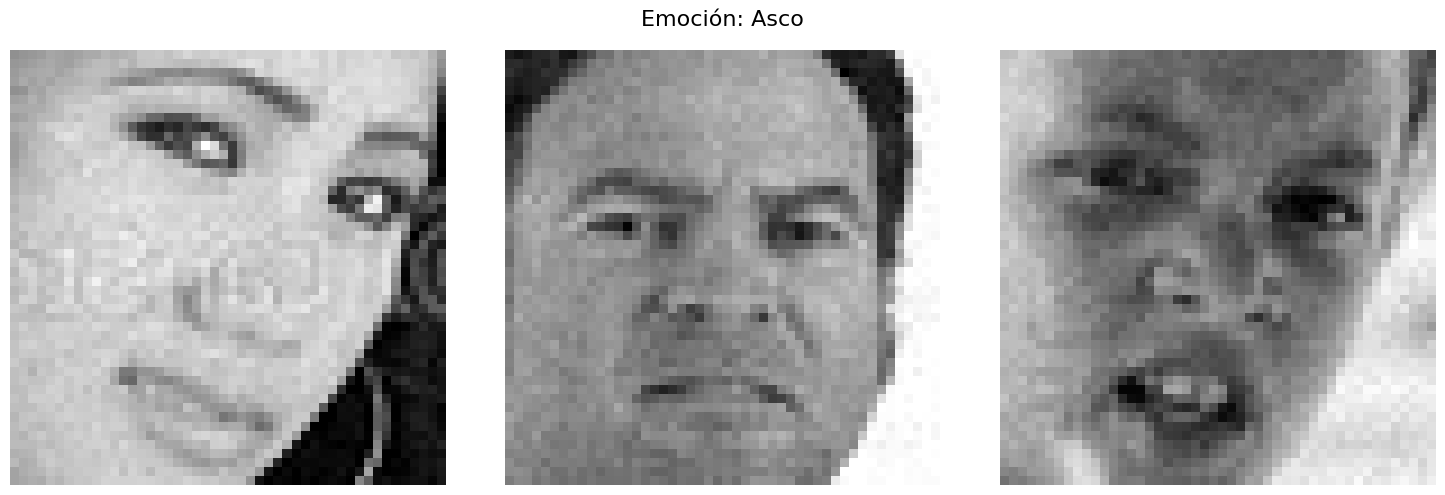

In [30]:
for emotion in [1]:
    mostrar_imagenes_emocion(df_test_ruido, emotion)

## **SE HACE AHORA A LA CLASE "5".**
>**Solo a 873 líneas, elegidas al azar, para df_train.**  
>**65 para el dataset de pruebas (test)**    
>**47 para el dataset de validación**  
>>**Lo sabenos viendo la diferencia que hay con el resto de etiquetas**

In [31]:
df_train_ruido_eti5 = df_train[df_train['emotion'] == 5] 
df_train_conruido = df_train_ruido_eti5.sample(n=873, random_state=42) 
df_train_conruido_control= df_train_conruido.copy()

df_test_ruido_eti5 = df_test[df_test['emotion'] == 5] 
df_test_conruido = df_test_ruido_eti5.sample(n=65, random_state=42) 


df_val_ruido_eti5 = df_val[df_val['emotion'] == 5] 
df_val_conruido = df_val_ruido_eti5.sample(n=47, random_state=42)

>**Con esto se filtra**

In [32]:
df_train_conruido.loc[:, 'pixels'] = df_train_conruido['pixels'].apply(lambda x: add_gaussian_noise(x, var=0.006)) 
df_test_conruido.loc[:, 'pixels'] = df_test_conruido['pixels'].apply(lambda x: add_gaussian_noise(x, var=0.006))
df_val_conruido.loc[:, 'pixels'] = df_val_conruido['pixels'].apply(lambda x: add_gaussian_noise(x, var=0.006))

## **VISUALIZACIÓN**
>**Solo SE visualizará el primero.**

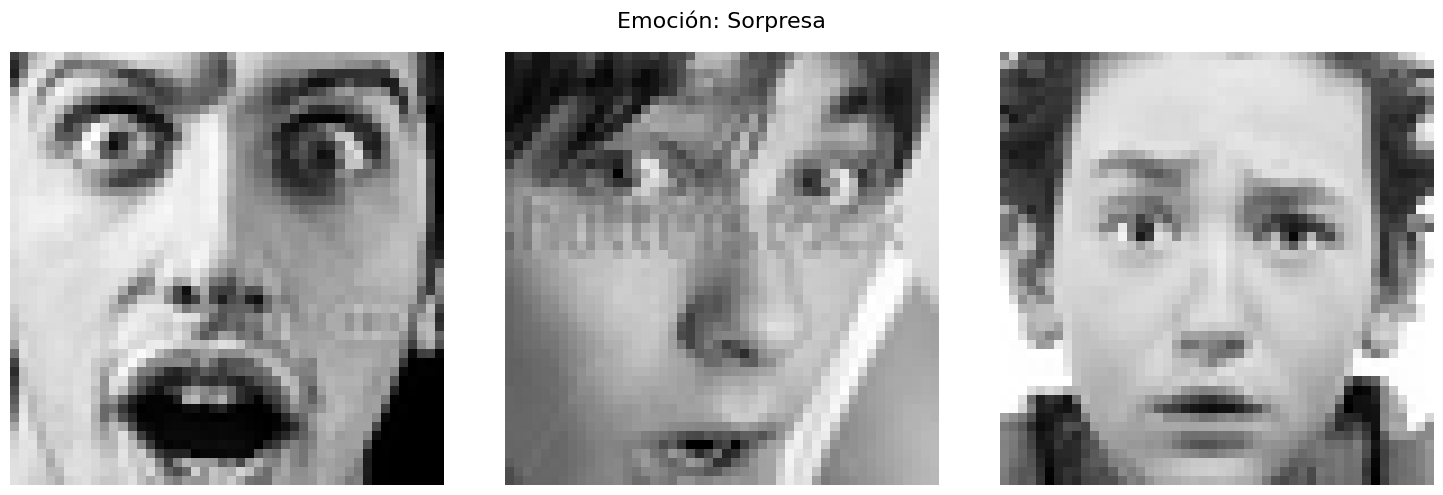

In [33]:
for emotion in [5]:
    mostrar_imagenes_emocion(df_train_conruido_control, emotion)

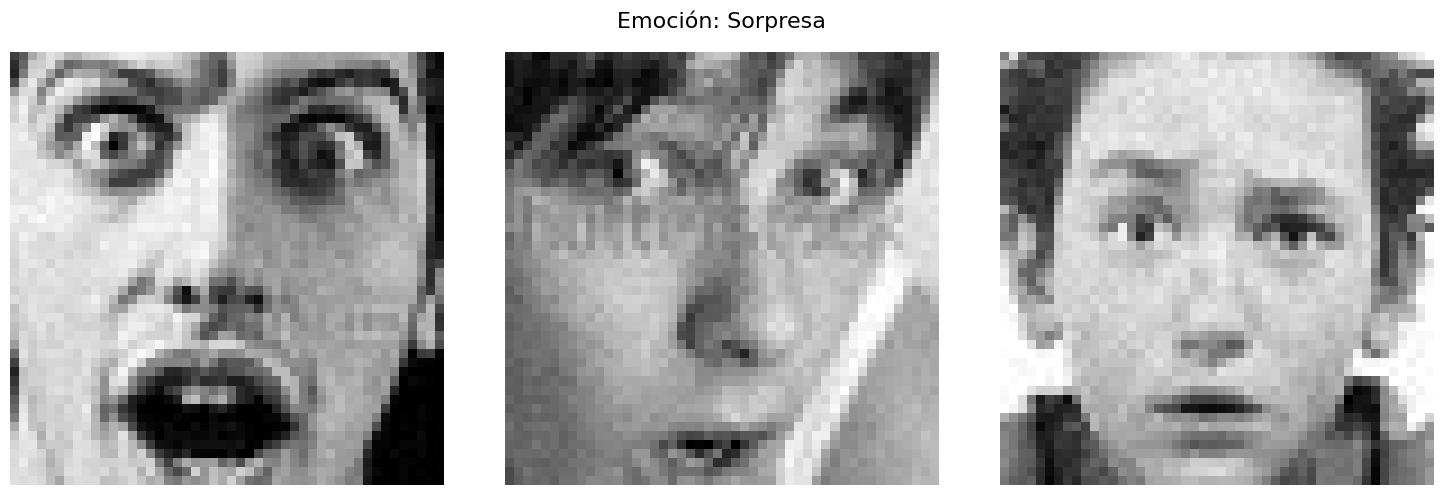

In [34]:
for emotion in [5]:
    mostrar_imagenes_emocion(df_train_conruido, emotion)

## **UNIÓN DE LOS DATASETS CON RUIDO CON EL RESTO**

In [35]:
df_train = pd.concat([df_train_ruido,df_train_conruido, df_train], ignore_index=True)
df_test = pd.concat([df_test_ruido,df_test_conruido, df_test], ignore_index=True)
df_val = pd.concat([df_val_ruido,df_val_conruido, df_val], ignore_index=True)  

## **COMPROBACIÓN**

In [36]:
print("El dataset de entenamiento ha quedado así:")
print(df_train['emotion'].value_counts())
print()
print("El dataset de validación ha quedado así:")
print(df_val['emotion'].value_counts())
print()
print("El dataset pruebas ha quedado así:")
print(df_test['emotion'].value_counts())

El dataset de entenamiento ha quedado así:
emotion
5    7215
6    7215
4    7215
2    7215
0    7215
3    7215
1    1744
Name: count, dtype: int64

El dataset de validación ha quedado así:
emotion
5    879
6    879
4    879
2    879
0    879
3    879
1    220
Name: count, dtype: int64

El dataset pruebas ha quedado así:
emotion
5    895
6    895
4    895
2    895
0    895
3    895
1    224
Name: count, dtype: int64


>**El proceso de data augmentation está cumpliendo con su objetivo: balancear el dataset.**  
**Solo queda por balancear la clase 1 (Asco).**

## **ROTACIONES**  
>**Solo queda balancear la clase 1; para ello, se haran pequeñas rotaciones hasta que el dataset esté balanceado.**

In [37]:
df_train_rota_meno5 = df_train[df_train['emotion'] == 1] 
df_train_rota_meno10 = df_train[df_train['emotion'] == 1] 
df_train_rota_ma10 = df_train[df_train['emotion'] == 1] 
df_train_rota_meno15 = seleccionar_aleatoriamente(df_train, 1, 239) #Para que quede completamente balanceada

df_train_rota_control = df_train[df_train['emotion'] == 1] 


df_test_rota_meno5 = df_test[df_test['emotion'] == 1]
df_test_rota_meno10 = df_test[df_test['emotion'] == 1]
df_test_rota_ma10 = df_test[df_test['emotion'] == 1]
df_test_rota_control = df_test[df_test['emotion'] == 1] 


df_val_rota_meno5 = df_val[df_val['emotion'] == 1]
df_val_rota_meno10 = df_val[df_val['emotion'] == 1]
df_val_rota_ma10 = df_val[df_val['emotion'] == 1]
df_val_rota_control = df_val[df_val['emotion'] == 1]

>**Aquí se filtran los dataframes para realizar diferentes rotaciones a la etiqueta 1.**


In [38]:
dataframes_test = [df_test_rota_meno5, df_test_rota_meno10, df_test_rota_ma10]
dataframes_val = [df_val_rota_meno5, df_val_rota_meno10, df_val_rota_ma10]

selected_dataframe_test = random.choice(dataframes_test)
random_index_test = random.randint(0, selected_dataframe_test.shape[0] - 1)
selected_dataframe_test.drop(selected_dataframe_test.index[random_index_test], inplace=True) 

selected_dataframe_val = random.choice(dataframes_val)
random_index_val = random.randint(0, selected_dataframe_val.shape[0] - 1)
selected_dataframe_val.drop(selected_dataframe_val.index[random_index_val], inplace=True)


>**Se elimina una fila al azar para que el balanceo sea perfecto.**

In [39]:
def rotate_image(image_str, angle):
    image = np.array(image_str.split(), dtype=np.uint8)
    image = image.reshape((48, 48))  # Las imágenes con las que trabajamos son de 48x48 píxeles
    rotated_image = rotate(image, angle, reshape=False, mode='nearest')
    rotated_image_str = ' '.join(rotated_image.astype(str).flatten())
    return rotated_image_str

>**Aquí se define la funcion que rotará las imagenes**

In [40]:
df_train_rota_meno5.loc[:, 'pixels'] = df_train_rota_meno5['pixels'].apply(lambda x: rotate_image(x, -5))  #aquí se elige el angulo de rotación.
df_train_rota_meno10.loc[:, 'pixels'] = df_train_rota_meno10['pixels'].apply(lambda x: rotate_image(x, -10))
df_train_rota_meno15.loc[:, 'pixels'] = df_train_rota_meno15['pixels'].apply(lambda x: rotate_image(x, -15))
df_train_rota_ma10.loc[:, 'pixels'] = df_train_rota_ma10['pixels'].apply(lambda x: rotate_image(x, 10))

df_test_rota_meno5.loc[:, 'pixels'] = df_test_rota_meno5['pixels'].apply(lambda x: rotate_image(x, -5))  
df_test_rota_meno10.loc[:, 'pixels'] = df_test_rota_meno10['pixels'].apply(lambda x: rotate_image(x, -10))
df_test_rota_ma10.loc[:, 'pixels'] = df_test_rota_ma10['pixels'].apply(lambda x: rotate_image(x, 10))  

df_val_rota_meno5.loc[:, 'pixels'] = df_val_rota_meno5['pixels'].apply(lambda x: rotate_image(x, -5)) 
df_val_rota_meno10.loc[:, 'pixels'] = df_val_rota_meno10['pixels'].apply(lambda x: rotate_image(x, -10))
df_val_rota_ma10.loc[:, 'pixels'] = df_val_rota_ma10['pixels'].apply(lambda x: rotate_image(x, 10))



>**Aquí se llama a la funcion.**

## **VISUALIZACIÓN**

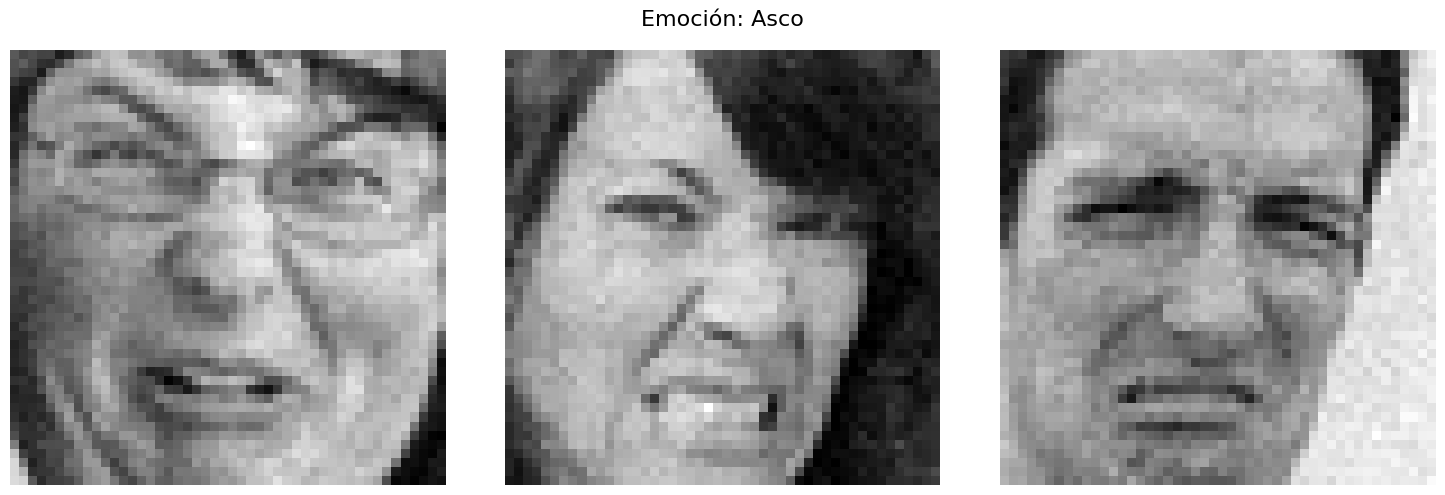

In [41]:
for emotion in [1]:
    mostrar_imagenes_emocion(df_train_rota_control, emotion)

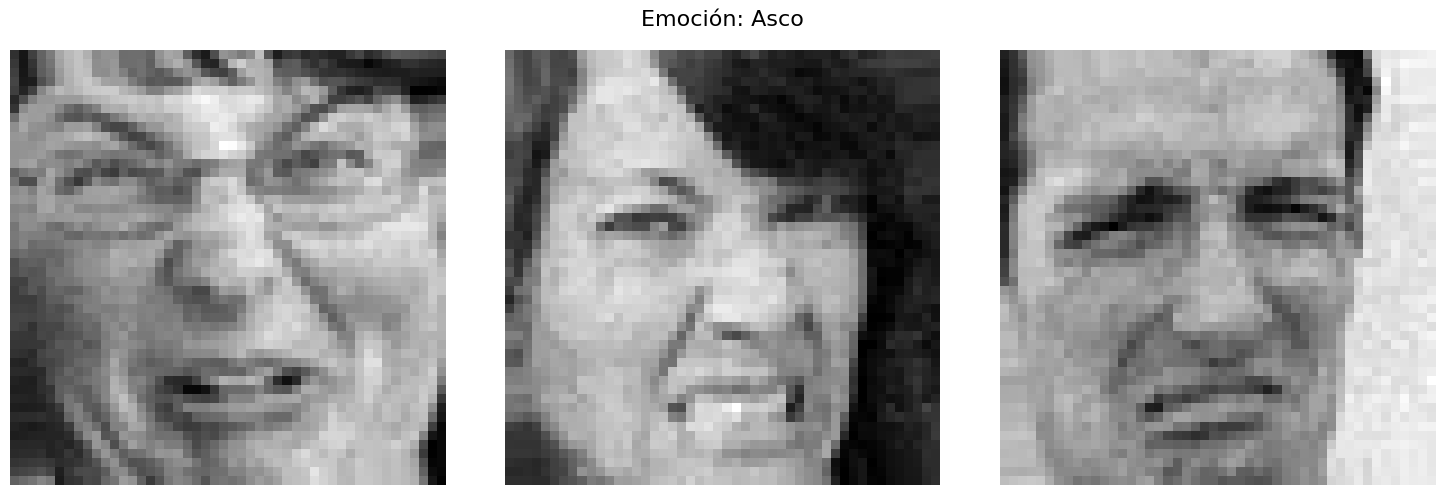

In [42]:
for emotion in [1]:
    mostrar_imagenes_emocion(df_train_rota_ma10, emotion)

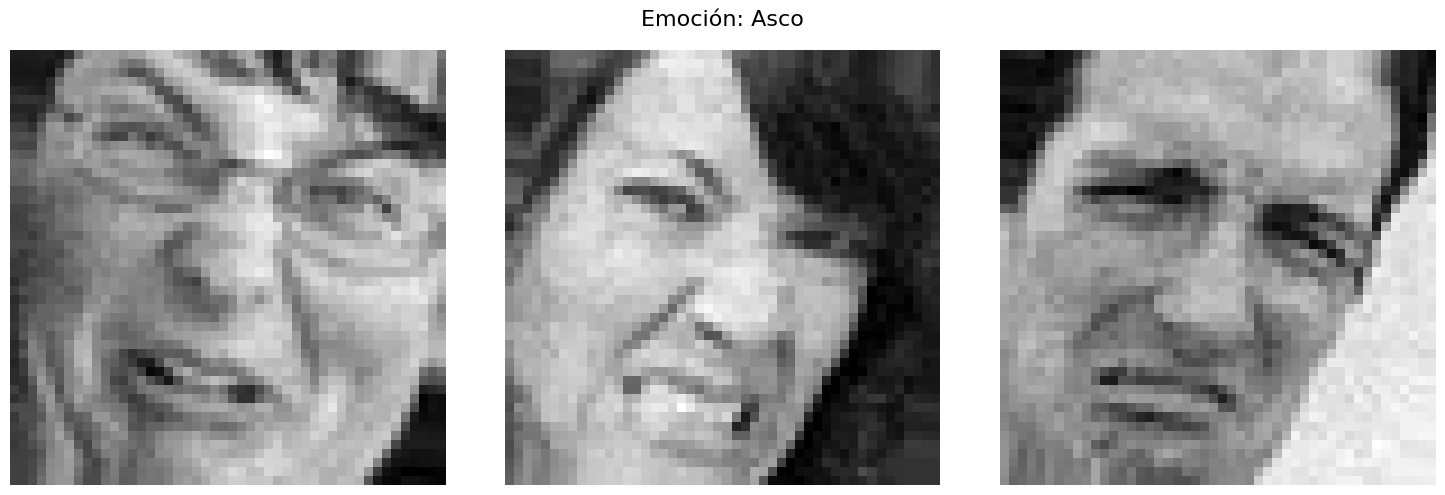

In [43]:
for emotion in [1]:
    mostrar_imagenes_emocion(df_train_rota_meno10, emotion)

## **UNIÓN DE LOS DATASETS ROTADOS CON EL RESTO**

In [44]:
df_train = pd.concat([df_train_rota_meno5,df_train_rota_meno10,df_train_rota_meno15,df_train_rota_ma10, df_train], ignore_index=True) 
df_test = pd.concat([df_test_rota_meno5, df_test_rota_meno10, df_test_rota_ma10, df_test], ignore_index=True)
df_val = pd.concat([df_val_rota_meno5, df_val_rota_meno10, df_val_rota_ma10, df_val], ignore_index=True)

## **COMPROBACIÓN**

In [45]:
print("El dataset de entenamiento ha quedado así:")
print(df_train['emotion'].value_counts())
print()
print("El dataset de validación ha quedado así:")
print(df_val['emotion'].value_counts())
print()
print("El dataset pruebas ha quedado así:")
print(df_test['emotion'].value_counts())

El dataset de entenamiento ha quedado así:
emotion
1    7215
5    7215
6    7215
4    7215
2    7215
0    7215
3    7215
Name: count, dtype: int64

El dataset de validación ha quedado así:
emotion
1    879
5    879
6    879
4    879
2    879
0    879
3    879
Name: count, dtype: int64

El dataset pruebas ha quedado así:
emotion
1    895
5    895
6    895
4    895
2    895
0    895
3    895
Name: count, dtype: int64


Tras el proceso de **data augmentation**, observamos que el dataset (el de entrenamiento, validación y pruebas) tiene sus distintas clases **balanceadas**. La **validación** y las **pruebas** parten de un dataset con el mismo número de filas, pero al finalizar el proceso, esto ya no es así, debido a que ese número de filas está distribuido de manera diferente para cada clase. La diferencia es pequeña, aproximadamente del **1.79%**.

Esta disparidad entre la **validación** y las **pruebas** es asumible. Continuar el proceso hasta lograr un **balance** total tiene la ventaja de estar equilibrado (valga la redundancia), pero también tiene una desventaja: al usar tantas veces las mismas fotos con pequeños cambios, podemos caer en un ligero **sobreajuste**.


## **UNIÓN DE LOS TRES DATASETS**

In [46]:
df_fer2013_balanceado = pd.concat([df_train,df_test,df_val], ignore_index=True) 

## **VISUALIZADO FINAL**

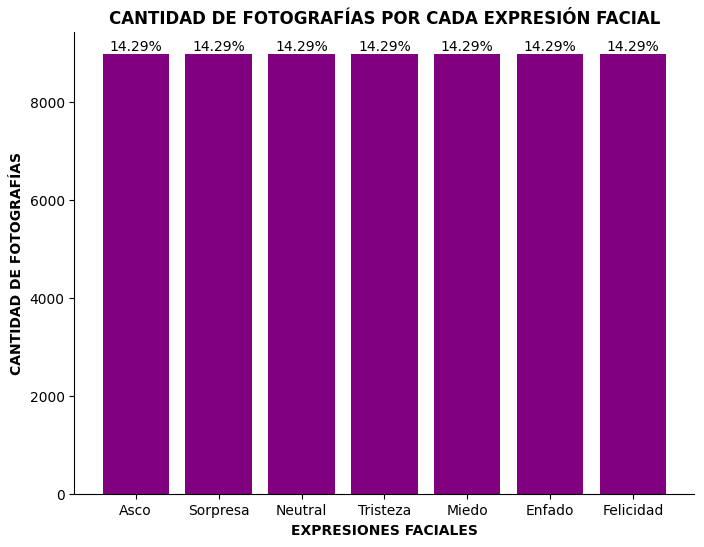

In [47]:

emotion_labels = {0: 'Enfado',1: 'Asco',2: 'Miedo',3: 'Felicidad',4: 'Tristeza',5: 'Sorpresa',6: 'Neutral'}

value_counts = df_fer2013_balanceado['emotion'].value_counts()
value_counts.index = value_counts.index.map(emotion_labels)
percentages = (value_counts / value_counts.sum()) * 100

plt.figure(figsize=(8, 6))
bars = plt.bar(value_counts.index, value_counts, color='purple')
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.2f}%', ha='center', va='bottom')
plt.title('CANTIDAD DE FOTOGRAFÍAS POR CADA EXPRESIÓN FACIAL', fontweight='bold')
plt.xlabel('EXPRESIONES FACIALES', fontweight='bold')
plt.ylabel('CANTIDAD DE FOTOGRAFÍAS', fontweight='bold')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xticks(rotation=0)  
plt.show()

## **GUARDADO DEL DATASET**

In [48]:
df_fer2013_balanceado.to_csv('./datos/fer2013/fer2013_blc.csv', index=False)

## **Resumen del Notebook de Aumentación de Datos en fer2013**

En este notebook se aborda el problema del desbalanceo de clases en el dataset fer2013.  
El desbalanceo puede afectar negativamente la capacidad de un modelo de reconocimiento facial  
para aprender de manera equitativa todas las emociones representadas.

### **Problema Abordado:**
El dataset fer2013 muestra un desbalance significativo en la cantidad de imágenes por cada emoción,    
con algunas emociones teniendo muchas más muestras que otras. Por ejemplo, la emoción "Asco",    
en el dataset original, tiene solo 547 imágenes, mientras que  otras emociones tienen casi 9000 imágenes.   
El problema se abordara en 3 dataset deribados del original, separandolos segun su uso (entrenamiento, validacion y pruebas) 


### **Solución Propuesta:**
Para abordar este desbalance, se aplicaron técnicas de aumento de datos como:    
>  
- **Volteo Horizontal:** Se generaron imágenes adicionales volteando horizontalmente las imágenes existentes,    
creando una copia 'reflejada en el espejo' para aumentar las clases menos representadas.    
>  
- **Añadido de Ruido Gaussiano:** Introducción de variaciones aleatorias en los niveles de intensidad de los píxeles de las imágenes.    
Esto ayuda a mejorar la capacidad del modelo para generalizar ante datos con imperfecciones similares. Se introdujo en las imágenes de    
las emociones "Asco" y "Sorpresa" (emociones 1 y 5) para crear variaciones sutiles en las imágenes y aumentar la diversidad del dataset.    
>  
- **Rotaciones:** Se aplicaron rotaciones a las imágenes de la emoción "Asco" en ángulos específicos (de -15° a +10°) para generar  
más variabilidad en las muestras. Se hizo una seleccion para que el balanceo fuera lo mejor posible.  

### **Resultados:**
Después de aplicar estas técnicas de aumento de datos, todas las emociones en el dataset fer2013 tienen la misma cantidad de imágenes,  
lo que equilibra efectivamente el desbalance inicial.  

### **Conclusión:**
Este notebook muestra cómo el aumento de datos puede ser utilizado para mejorar la calidad y equidad de un modelo de reconocimiento  
facial al balancear el número de muestras por cada emoción representada en el dataset fer2013. Las técnicas aplicadas aseguran que  
el modelo pueda aprender de manera equitativa de todas las clases emocionales, mejorando así su rendimiento en la tarea de reconocimiento facial.  
Es importante tener en cuenta que el uso excesvo de este proceso puede traer consigo problemas de sobreajuste.